
## Group Name : Unfiltered Commentary

- Raees Moosa : 2322203
- Oriinga Maudu : 2433303
- Tumi Jourdan : 2180153


In [1]:
"""this is just for me since gpu bugged"""
# %env CUDA_VISIBLE_DEVICES=1

'this is just for me since gpu bugged'

In [20]:
# MAIN IMPORTS 
import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter

from tqdm import tqdm
from torchviz import make_dot
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.optim as optim
import os
import torchvision.transforms as T
from skimage import transform as sktf
from skimage.util import random_noise
import random
import segmentation_models_pytorch as smp

# https://pytorch.org/tutorials/beginner/introyt/modelsyt_tutorial.html - documetnation on how to make a pytorch model

c:\Users\Oriin\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data preprocessing 
- dataloaders
- augmentation pipeline
## Add notes on this here (what is happening)
- added some transforms that are vert and hor flips including rotation
- [ ] TODO Add random noise shapes in the image outside the mask maybe that will help the model learn better

In [17]:
#data loader
# the images are loaded as float32 and normalised
# the mask is thresholded at 0.5 
""" the permute is needed since the format for image tensors must be (C, H, W)
But when we read from opencv the shape is (H, W, C)
and the mask must be of dim (1, H, W) since single channel - unsqueeze add this channel
"""
# returned as tensors 

class PuzzleDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None, num_transforms=0,include_inverse_mask=True):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.num_transforms = num_transforms
        self.include_inverse_mask=include_inverse_mask
        images = sorted(os.listdir(img_dir))
        masks = sorted(os.listdir(mask_dir))
        self.data = []

        for i in range(len(images)):
            img_path = os.path.join(self.img_dir, images[i])
            mask_path = os.path.join(self.mask_dir, masks[i])

          
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (512, 512))
            image = image.astype(np.float32)/255.0
            # image = Image.fromarray(image)  

            
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, (512,512))
            mask = (mask > 0.5).astype(np.float32) 
            # mask = Image.fromarray(mask)  #   PIL image needed for transforms

            # store the original image and mask
            self.append_image_mask(image, mask)

            # do transformations 
            for _ in range(self.num_transforms):
                transformed_image, transformed_mask = self.apply_transform(image, mask)
                self.append_image_mask(transformed_image, transformed_mask)

    def apply_transform(self, image, mask):
        """Apply deterministic transformations to both image and mask
        This is imortant since using the torchvision.transforms was givin a random transform
        for both image and mask -> they didn't match up"""
        if self.transform:
            
            if random.random() > 0.5:
                image = np.fliplr(image)
                mask = np.fliplr(mask)

           
            if random.random() > 0.5:
                image = np.flipud(image)
                mask = np.flipud(mask)

            # Apply rotation deterministically
            angle = np.random.uniform(-30, 30)
            image = sktf.rotate(image, angle, mode="edge" , preserve_range=True)
            mask = sktf.rotate(mask, angle, mode="edge" , preserve_range=True)

        return image, mask

    def append_image_mask(self, image, mask):
        """need to store them as tensors."""
        image = torch.tensor(image.transpose((2, 0, 1)), dtype=torch.float32) # (C, H, W)
        mask = torch.tensor(mask[None, ...], dtype=torch.float32)   # (1, H, W)

       
        if(self.include_inverse_mask):
            inverse_mask = 1 - mask
            combined_mask = torch.cat([inverse_mask, mask], dim=0)  # Combined (2, H, W)

        
            self.data.append((image, combined_mask))
        else:
            self.data.append((image,mask))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


Loading the training dataset
- NOTE increasing batch size to 5 since our dataset size is up to 40 now

40
torch.Size([2, 512, 512])


(<Axes: >, <matplotlib.image.AxesImage at 0x239a9c505d0>)

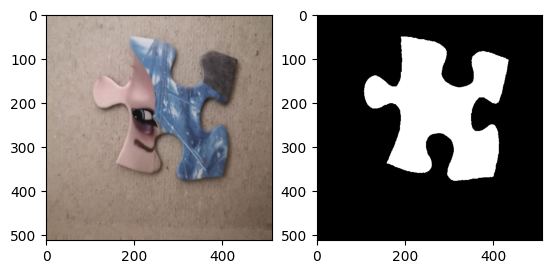

In [18]:
#  list of transformations
# transform_list = [
#     T.RandomHorizontalFlip(),
#     T.RandomVerticalFlip(),
#     T.RandomRotation(30),
# ]


train_dataset = PuzzleDataset(
    img_dir="./images-1024x768/train/",
    mask_dir="./masks-1024x768/train/", 
    transform=True,
    num_transforms=3  
)
#since 10 images batches of 1 should be fine can do like batches of 2 i guess                        
# note we now have more images since transform applied so maybe adjust batches
train_loader = DataLoader(train_dataset,batch_size =2, shuffle=True)

print(len(train_dataset.data))
# # to visualise the images + masks are in correct pairing
image, mask = train_dataset[6]

image_np = (image.permute(1, 2, 0).numpy() * 255).astype(np.uint8)
mask_np = mask.permute(1, 2, 0).numpy()
print(mask.shape)


#to collapse the separate channels of bg and fg mask
if mask_np.shape[2] == 2:
    mask_np = np.argmax(mask_np, axis=2)
    
plt.figure()
plt.subplot(1,2,1), plt.imshow(image_np)
plt.subplot(1,2,2), plt.imshow(mask_np, cmap="gray")



In [19]:
val_dataset = PuzzleDataset(
    img_dir="./images-1024x768/val/",
    mask_dir="./masks-1024x768/val/", 
)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

test_dataset = PuzzleDataset(img_dir = "./images-1024x768/test/",
                            mask_dir = "./masks-1024x768/test/")
#since 10 images batches of 1 should be fine can do like batches of 2 i guess                        
test_loader = DataLoader(test_dataset,batch_size =1, shuffle=True)

# 3.1 Unet Construction
## Add notes on this here (what is happening)

In [6]:
""" Adding checkpoints as required and to avoid training everytime someone wants to test"""
def save_checkpoint(model, optimizer, epoch, filename="checkpoint.pth"):
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch,
    }
    torch.save(checkpoint, filename)
    print(f"Checkpoint saved at epoch {epoch}.")


# use as in training
"""save_checkpoint(model, optimizer, epoch)"""


def load_checkpoint(model, optimizer, filename="checkpoint.pth"):
    if os.path.isfile(filename):
        checkpoint = torch.load(filename)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch = checkpoint['epoch']
        print(f"Checkpoint loaded from epoch {epoch}.")
        return epoch
    else:
        print("No checkpoint found.")
        return 0  # training from start ...

# before training starts to load model
"""start_epoch = load_checkpoint(model, optimizer)"""


'start_epoch = load_checkpoint(model, optimizer)'

In [7]:
""" helper to clear the gpu of datasets and model"""
def clear_gpu_memory(model=None, data_loaders=None):
    
    if model is not None:
        model.cpu()
        del model
    
    
    if data_loaders is not None:
        for loader in data_loaders:
            del loader  
    
    #  garbage collection
    gc.collect()
    
    torch.cuda.empty_cache()

## Vairant 1 : Using `torch.nn.ConvTranspose2d` for upsampling
- We removed the softmax in the unet with convolve to get to the required number of output classes (ask richard).
- Having the argmax inside the network caused issues with backprop so we only compute the raw logits and use these for the BCE loss
then use the apply softmax outside when performing inference on the test set.

In [8]:
# So this is the triple convolution, chat gpt says we should use normalization dont know if we should keep it
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.triple_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.triple_conv(x)
    
class Conv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Conv, self).__init__()
        self.triple_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.triple_conv(x)

    
# the down module is what the unet uses during the first half 
class Down(nn.Module):
    def __init__(self, in_channels,out_channels):
        super(Down, self).__init__()
        self.conv_pool = nn.Sequential(
            nn.MaxPool2d(kernel_size=2,stride=2,padding=0),
            DoubleConv(in_channels,out_channels)
        )

    def forward(self, x):
        ret_ = self.conv_pool(x)
        return ret_

# up transpose, 
class UpConvTranspose(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpConvTranspose, self).__init__()
        # to determine amount of out channels
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv = Conv(out_channels, out_channels)

    def forward(self,x):
        x = self.up(x)
        return self.conv(x)

class UpBilinear(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpBilinear, self).__init__()
        # the bilinear is provided by the nn module, we set the mode to bilinear here
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv = Conv(out_channels, out_channels)

    def forward(self,x):
        x = self.up(x)
        return self.conv(x)
    
class Up(nn.Module):
    def __init__(self, in_channels, out_channels,mode):
        super(Up, self).__init__()
        if(mode=='convtranspose'):
            self.conv_pool = nn.Sequential(
                UpConvTranspose(in_channels,out_channels),
                Conv(out_channels,out_channels)
            )
        else:
            self.conv_pool = nn.Sequential(
                UpBilinear(in_channels,out_channels),
                Conv(out_channels,out_channels)
            )
        
        self.dconv = DoubleConv(out_channels*2,out_channels)
    
    def forward(self,x1,x2):
        x = self.conv_pool(x1)
        return self.dconv(torch.cat([x,x2],dim=1))

    
class SoftMax(nn.Module):
    def __init__(self, in_channels):
        super(SoftMax, self).__init__()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.softmax(x)
        return torch.argmax(x,dim=1)

class Unet(nn.Module):
    def __init__(self, n_channels, n_classes, variant='convtranspose'):
        super(Unet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.variant = variant

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64,128)
        self.down2 = Down(128,256)
        self.down3 = Down(256,512)
        self.down4 = Down(512,1024)
        
        self.up1 = Up(1024,512,variant)
        self.up2 = Up(512, 256,variant)
        self.up3 = Up(256, 128,variant)
        self.up4 = Up(128, 64,variant)

        self.outc = nn.Conv2d(64,2, kernel_size=1)


    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        
        logits = self.outc(x)
        
        return logits
    

In [9]:
def calculate_iou(preds, targets, threshold=0.5):
    # Make sure predictions and targets are 4D: [batch_size, channels, height, width]
    if preds.dim() == 3:
        preds = preds.unsqueeze(0)  # Add batch dimension
    if targets.dim() == 3:
        targets = targets.unsqueeze(0)  # Add batch dimension

    preds = (torch.sigmoid(preds) > threshold).float()
    
    # Calculate intersection and union
    intersection = torch.sum(preds * targets, dim=[2, 3])
    union = torch.sum(preds, dim=[2, 3]) + torch.sum(targets, dim=[2, 3]) - intersection
    
    # Calculate IoU
    iou = (intersection + 1e-6) / (union + 1e-6)  # Add small epsilon to avoid division by zero
    
    return iou.mean().item()

NOTE: I just pushed to the cpu when I try putting the model on the gpu I get weird errors in training 
that I used up all the GPU memory maybe you wont get this error then just comment out `device="cpu"
`

In [10]:
""" Training UNET Variant 1
    torch.nn.ConvTranspose2d """

import gc
import wandb
wandb.init(project="Unet variant 1")

# I forced the device to cpu since I have no gpu comment that line out!

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")



# Model, criterion, and optimizer setup
model = Unet(n_channels=3, n_classes=2, variant='convtranspose')

# if torch.cuda.device_count() > 1:
#     print("Using", torch.cuda.device_count(), "GPUs!")
#     model = model.to('cuda:1')

model = model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)

#  checkpoints if any
start_epoch = load_checkpoint(model, optimizer, filename="var1_checkpoint.pth")

num_epochs = 50
best_val_loss = float('inf')

for epoch in range(start_epoch, num_epochs):
    
    # print(torch.cuda.memory_summary())

    
    model.train()  
    running_loss = 0.0
    train_iou = 0.0
    
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        # outputs = outputs.float()
        # outputs = torch.softmax(outputs, dim=1)

        # print(f"Outputs min: {outputs.min()}, max: {outputs.max()}, shape: {outputs.shape}")
        # print(f"Masks min: {masks.min()}, max: {masks.max()}, shape: {masks.shape}")
        
        # BCE loss with logits 
        loss = criterion(outputs, masks)
        loss.backward()
        #gradient clipping I dunno why we get nans
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
        optimizer.step()

        #softmax to logits to then get the IoU
        
        
        #  loss and IoU
        running_loss += loss.item()
        train_iou += calculate_iou(outputs, masks)

    train_loss = running_loss / len(train_loader)
    train_iou = train_iou / len(train_loader)

    
    model.eval()
    val_loss = 0.0
    val_iou = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()
            
            val_iou += calculate_iou(outputs, masks)

    val_loss = val_loss / len(val_loader)
    val_iou = val_iou/ len(val_loader)


    #  training and validation metrics to wandb
    wandb.log({"epoch": epoch, "train_loss": train_loss, "val_loss": val_loss, "train_iou": train_iou, "val_iou": val_iou})
    
    
    # print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader)}")
    
    # store model checkpoint if validation loss improves
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        save_checkpoint(model,optimizer, epoch, "var1_checkpoint.pth")
        print(f"Checkpoint saved at epoch {epoch + 1}")

    # model.cpu()
    # del model
    gc.collect() 
    torch.cuda.empty_cache()
    
    # print(torch.cuda.memory_summary())


# close wandb run


# run tensorboard --logdir=runs to see networkls


AttributeError: module 'wandb' has no attribute 'init'

In [11]:
def display_tensor_as_image(tensor, channel_num, channel_index, height_index, width_index):
    # Move the tensor to CPU and convert it to a NumPy array
    tensor_np = tensor.cpu().numpy()
    if channel_index == 1:
        tensor_np = tensor_np.squeeze(0)

        channel_index -=1
        height_index-=1
        width_index-=1
        
    # Handle single-channel (grayscale) image
    if channel_num == 1:
        image_np = tensor_np.squeeze(channel_index)  # Remove the channel dimension
        plt.imshow(image_np, cmap="gray")
        plt.title("Single-channel image")
        plt.show()
    
    # Handle two-channel image (display channels separately)
    elif channel_num == 2:
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # Create 1 row, 2 columns
        for i in range(2):
            channel_image = tensor_np[i]  # Select each channel (e.g., 0 and 1)
            axes[i].imshow(channel_image, cmap="gray")
            axes[i].set_title(f"Channel {i}")
            # print(f"Max value in channel {i}:", np.max(channel_image))
            # print(f"Min value in channel {i}:", np.min(channel_image))
        plt.show()
    
    # Handle three-channel image (RGB)
    elif channel_num == 3:
        print(tensor_np.shape)
        # Transpose from (channels, height, width) to (height, width, channels)
        image_np = np.transpose(tensor_np, (height_index, width_index, channel_index))
        plt.imshow(image_np)
        plt.title("Three-channel image (RGB)")
        plt.show()


In [12]:
def evaluate_model_on_test_loader(model, test_loader, device, show_plot=False):
    model.eval() 
    total_iou = 0.0
    num_samples = 0

    with torch.no_grad():
        for image, mask in test_loader:
            images = image.to(device)
            masks = mask.to(device)  
            
            outputs = model(images)
            total_iou += calculate_iou(predicted_mask, masks) 
            #  softmax
            probs = torch.softmax(outputs, dim=1)

            #  predicted mask
            predicted_mask = torch.argmax(probs, dim=1)  #dim=1 for batch predictions

            # IoU for the current batch
            
            num_samples += 1

            if show_plot:
                display_tensor_as_image(images, 3, 1, 2, 3)
                image_np = predicted_mask.squeeze().cpu().numpy()
                plt.imshow(image_np, vmin=0, vmax=1, cmap='gray')
                plt.axis('off')  
                plt.show()

    mean_iou = total_iou / len(test_loader)
    print(f"Mean IoU on the test set: {mean_iou:.4f}")
    
    # mean IoU to wandb
    # wandb.log({"test_mean_iou": mean_iou})
    
    return mean_iou

# Testing the model


In [13]:

del model
model = Unet(n_channels=3, n_classes=2, variant='convtranspose')
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-5)

load_checkpoint(model, optimizer, filename="var1_checkpoint.pth")

mean_iou = evaluate_model_on_test_loader(model, test_loader, device, show_plot=True)
wandb.log({"test_mean_iou": mean_iou})
wandb.finish()
""" DELETING THE MODEL HERE TO FREE UP VRAM!!!!
 BUT ALSO so i dont have rename the model variable from the  previous block in later sections"""
clear_gpu_memory(model, [train_loader, val_loader, test_loader])


NameError: name 'model' is not defined

## Vairant 2: Using `torch.nn.Upsample` for bilinear upsampling

In [14]:

wandb.init(project="Unet variant 2 - bilinear upsampling")


model = Unet(n_channels=3, n_classes=2,variant='upsampling')

# if torch.cuda.device_count() > 1:
#     print("Using", torch.cuda.device_count(), "GPUs!")
#     model = model.to('cuda:1')

model = model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)

#  checkpoints if any
start_epoch = load_checkpoint(model, optimizer, filename="var2_checkpoint.pth")

num_epochs = 50
best_val_loss = float('inf')

for epoch in range(start_epoch, num_epochs):
    
    # print(torch.cuda.memory_summary())

    
    model.train()  
    running_loss = 0.0
    train_iou = 0.0
    
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        # outputs = outputs.float()
        # outputs = torch.softmax(outputs, dim=1)

        # print(f"Outputs min: {outputs.min()}, max: {outputs.max()}, shape: {outputs.shape}")
        # print(f"Masks min: {masks.min()}, max: {masks.max()}, shape: {masks.shape}")
        
        # BCE loss with logits 
        loss = criterion(outputs, masks)
        loss.backward()
        #gradient clipping I dunno why we get nans
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
        optimizer.step()

        
        
        #  loss and IoU
        running_loss += loss.item()
        train_iou += calculate_iou(outputs, masks)

    train_loss = running_loss / len(train_loader)
    train_iou = train_iou/ len(train_loader)

    
    model.eval()
    val_loss = 0.0
    val_iou = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()
            
            val_iou += calculate_iou(outputs, masks)

    val_loss = val_loss / len(val_loader)
    val_iou = val_iou /len(val_loader)


    #  training and validation metrics to wandb
    wandb.log({"epoch": epoch, "train_loss": train_loss, "val_loss": val_loss, "train_iou": train_iou, "val_iou": val_iou})
    
    
    # print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader)}")
    
    # store model checkpoint if validation loss improves
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        save_checkpoint(model,optimizer, epoch, "var2_checkpoint.pth")
        print(f"Checkpoint saved at epoch {epoch + 1}")

    # model.cpu()
    # del model
    gc.collect() 
    torch.cuda.empty_cache()
    
    # print(torch.cuda.memory_summary())




No checkpoint found.
Checkpoint saved at epoch 1
Checkpoint saved at epoch 2
Checkpoint saved at epoch 3
Checkpoint saved at epoch 4
Checkpoint saved at epoch 5
Checkpoint saved at epoch 9
Checkpoint saved at epoch 12
Checkpoint saved at epoch 13
Checkpoint saved at epoch 16
Checkpoint saved at epoch 33
Checkpoint saved at epoch 34
Checkpoint saved at epoch 45


# Testing the second base variant here:

In [15]:
test_dataset = PuzzleDataset(img_dir = "./images-1024x768/test/",
                            mask_dir = "./masks-1024x768/test/")
#since 10 images batches of 1 should be fine can do like batches of 2 i guess                        
test_loader = DataLoader(test_dataset,batch_size =1, shuffle=True)


del model
model = Unet(n_channels=3, n_classes=2,variant='upsampling')
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-5)

load_checkpoint(model, optimizer, filename="var2_checkpoint.pth")

mean_iou = evaluate_model_on_test_loader(model, test_loader, device, show_plot=True)
wandb.log({"test_mean_iou": mean_iou})
wandb.finish()
""" DELETING THE MODEL HERE TO FREE UP VRAM!!!!
 BUT ALSO so i dont have rename the model variable from the  previous block in later sections"""
clear_gpu_memory(model, [train_loader, val_loader, test_loader])


/tmp/ipykernel_1736246/3703089074.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filename)


KeyError: 'model_state_dict'

### Evaluation
evaluate model on test set 
- accuracy
- precision
- recall
- F1 score
- IoU

# Select the best model based on the validation IoU and report its performance on the test set

asdasdasfafasd

# 4 Other architectures


In [ ]:
#!pip install -U git+https://github.com/qubvel-org/segmentation_models.pytorch
#!pip install lightning albumentations

In [47]:
import segmentation_models_pytorch as smp
import pytorch_lightning as pl
from torch.optim import lr_scheduler

In [48]:
train_dataset = PuzzleDataset(
    img_dir="./images-1024x768/train/",
    mask_dir="./masks-1024x768/train/", 
    transform=True,
    num_transforms=3,
    include_inverse_mask=False 
)
val_dataset = PuzzleDataset(
    img_dir="./images-1024x768/val/",
    mask_dir="./masks-1024x768/val/",
    include_inverse_mask=False
)

test_dataset = PuzzleDataset(
    img_dir = "./images-1024x768/test/",
    mask_dir = "./masks-1024x768/test/",
    include_inverse_mask=False

)

train_dataloader = DataLoader(train_dataset,batch_size=5,shuffle=True)
val_dataloader = DataLoader(val_dataset,batch_size=5,shuffle=False)
test_dataloader = DataLoader(test_dataset,batch_size=1,shuffle=False)

In [49]:
EPOCHS = 10
T_MAX = EPOCHS * len(train_dataloader)
OUT_CLASSES = 1

class UnetPlus(pl.LightningModule):
    def __init__(self, arch, encoder_name, in_channels, out_classes, **kwargs):
        super().__init__()
        self.model = smp.create_model(
            arch,
            encoder_name=encoder_name,
            in_channels=in_channels,
            classes=out_classes,
            **kwargs,
        )
        # preprocessing parameteres for image
        params = smp.encoders.get_preprocessing_params(encoder_name)
        self.register_buffer("std", torch.tensor(params["std"]).view(1, 3, 1, 1))
        self.register_buffer("mean", torch.tensor(params["mean"]).view(1, 3, 1, 1))

        # for image segmentation dice loss could be the best first choice
        self.loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)

        # initialize step metics
        self.training_step_outputs = []
        self.validation_step_outputs = []
        self.test_step_outputs = []

    def forward(self, image):
        # normalize image here
        image = (image - self.mean) / self.std
        mask = self.model(image)
        return mask

    def shared_step(self, batch, stage):
        #print("batch:",batch[0].shape)
        image, mask = batch
        #image = batch["image"]

        # Shape of the image should be (batch_size, num_channels, height, width)
        # if you work with grayscale images, expand channels dim to have [batch_size, 1, height, width]
        assert image.ndim == 4

        # Check that image dimensions are divisible by 32,
        # encoder and decoder connected by `skip connections` and usually encoder have 5 stages of
        # downsampling by factor 2 (2 ^ 5 = 32); e.g. if we have image with shape 65x65 we will have
        # following shapes of features in encoder and decoder: 84, 42, 21, 10, 5 -> 5, 10, 20, 40, 80
        # and we will get an error trying to concat these features
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        #mask = batch["mask"]
        assert mask.ndim == 4

        # Check that mask values in between 0 and 1, NOT 0 and 255 for binary segmentation
        assert mask.max() <= 1.0 and mask.min() >= 0

        logits_mask = self.forward(image)
        #print(f"Logits mask shape: {logits_mask.shape}, Target mask shape: {mask.shape}")


        # Predicted mask contains logits, and loss_fn param `from_logits` is set to True
        loss = self.loss_fn(logits_mask, mask)

        # Lets compute metrics for some threshold
        # first convert mask values to probabilities, then
        # apply thresholding
        prob_mask = logits_mask.sigmoid()
        pred_mask = (prob_mask > 0.5).float()

        # We will compute IoU metric by two ways
        #   1. dataset-wise
        #   2. image-wise
        # but for now we just compute true positive, false positive, false negative and
        # true negative 'pixels' for each image and class
        # these values will be aggregated in the end of an epoch
        tp, fp, fn, tn = smp.metrics.get_stats(
            pred_mask.long(), mask.long(), mode="binary"
        )
        return {
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
        }

    def shared_epoch_end(self, outputs, stage):
        losses = torch.stack([x["loss"] for x in outputs]).mean()
        self.log(f"val_loss", losses, prog_bar=True)
        # aggregate step metics
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])

        #F1 score
        precision = tp.sum() / (tp.sum() + fp.sum() + 1e-6)  # Add small value to avoid division by zero
        recall = tp.sum() / (tp.sum() + fn.sum() + 1e-6)     # Add small value to avoid division by zero
        f1_score = 2 * (precision * recall) / (precision + recall + 1e-6)    

        #accuracy
        accuracy = (tp.sum()+tn.sum())/(tp.sum(),tn.sum()+fp.sum()+fn.sum())

        # per image IoU means that we first calculate IoU score for each image
        # and then compute mean over these scores
        per_image_iou = smp.metrics.iou_score(
            tp, fp, fn, tn, reduction="micro-imagewise"
        )

        # dataset IoU means that we aggregate intersection and union over whole dataset
        # and then compute IoU score. The difference between dataset_iou and per_image_iou scores
        # in this particular case will not be much, however for dataset
        # with "empty" images (images without target class) a large gap could be observed.
        # Empty images influence a lot on per_image_iou and much less on dataset_iou.
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
        metrics = {
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
            f"{stage}_f1_score": f1_score, # Log the F1 score
            f"{stage}_precision": precision,
            f"{stage}_accuracy": accuracy,
        }

        self.log_dict(metrics, prog_bar=True)

    def training_step(self, batch, batch_idx):
        train_loss_info = self.shared_step(batch, "train")
        # append the metics of each step to the
        self.training_step_outputs.append(train_loss_info)
        return train_loss_info

    def on_train_epoch_end(self):
        self.shared_epoch_end(self.training_step_outputs, "train")
        # empty set output list
        self.training_step_outputs.clear()
        return

    def validation_step(self, batch, batch_idx):
        valid_loss_info = self.shared_step(batch, "valid")
        self.validation_step_outputs.append(valid_loss_info)
        return valid_loss_info

    def on_validation_epoch_end(self):
        self.shared_epoch_end(self.validation_step_outputs, "valid")
        self.validation_step_outputs.clear()
        return

    def test_step(self, batch, batch_idx):
        test_loss_info = self.shared_step(batch, "test")
        self.test_step_outputs.append(test_loss_info)
        return test_loss_info

    def on_test_epoch_end(self):
        self.shared_epoch_end(self.test_step_outputs, "test")
        # empty set output list
        self.test_step_outputs.clear()
        return

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=2e-4)
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_MAX, eta_min=1e-5)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "step",
                "frequency": 1,
            },
        }
        return

### 1. Resnet 34

In [50]:
UnetRes = UnetPlus("Unet","resnet34",3,1)

In [ ]:
trainer = pl.Trainer(max_epochs=EPOCHS,log_every_n_steps=1)

trainer.fit(
    UnetRes,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader
)

In [ ]:
#Load model
UnetRes = smp.from_pretrained('./resnet/resnet')

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

In [ ]:
#run validation dataset
valid_metrics = trainer.validate(UnetRes, dataloaders=val_dataloader, verbose=False)
print(valid_metrics)

In [ ]:
# run test dataset
test_metrics = trainer.test(UnetRes, dataloaders=test_dataloader, verbose=False)
print(test_metrics)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mean_iou = evaluate_model_on_test_loader(UnetRes, test_dataloader, device, show_plot=True)

In [ ]:
#Save model
smp_model = UnetRes.model

commit_info = smp_model.save_pretrained(
    save_directory="saved_models/UnetPlus/UnetRes",
)

### 2. Unet VGG

In [ ]:
UnetVGG = UnetPlus("Unet","vgg11",3,1)

In [ ]:
trainer = pl.Trainer(max_epochs=EPOCHS,log_every_n_steps=1)

trainer.fit(
    UnetVGG,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader
)

In [ ]:
#Load model
UnetVGG = smp.from_pretrained('./vgg/vgg11')

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

In [ ]:
#run validation dataset
valid_metrics = trainer.validate(UnetVGG, dataloaders=val_dataloader, verbose=False)
print(valid_metrics)

In [ ]:
# run test dataset
test_metrics = trainer.test(UnetVGG, dataloaders=test_dataloader, verbose=False)
print(test_metrics)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mean_iou = evaluate_model_on_test_loader(UnetVGG, test_dataloader, device, show_plot=True)

In [ ]:
#Save model
smp_model = UnetVGG.model

commit_info = smp_model.save_pretrained(
    save_directory="saved_models/UnetPlus/UnetVGG",
)

### 3. Unet Mobileone

In [51]:
UnetMobile = UnetPlus("Unet","mobileone_s2",3,1)

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

In [ ]:
trainer = pl.Trainer(max_epochs=EPOCHS,log_every_n_steps=1)

trainer.fit(
    UnetMobile,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader
)

In [52]:
#Load model
UnetMobile = smp.from_pretrained('./mobile/mobile')

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

In [ ]:
#run validation dataset
valid_metrics = trainer.validate(UnetMobile, dataloaders=val_dataloader, verbose=False)
print(valid_metrics)

In [ ]:
# run test dataset
test_metrics = trainer.test(UnetMobile, dataloaders=test_dataloader, verbose=False)
print(test_metrics)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mean_iou = evaluate_model_on_test_loader(UnetVGG, test_dataloader, device, show_plot=True)

In [ ]:
#Save model
smp_model = UnetMobile.model

commit_info = smp_model.save_pretrained(
    save_directory="saved_models/UnetPlus/UnetMobile",
)

## DeepLabV3

In [ ]:
# Deep lab v3
EPOCHS = 30
T_MAX = EPOCHS * len(train_dataloader)
OUT_CLASSES = 2

class DeepV_plus(pl.LightningModule):
    def __init__(self, arch, encoder_name, in_channels, out_classes, pretrained="imagenet", **kwargs):
        super().__init__()
        self.model = smp.create_model(
            arch,
            encoder_name=encoder_name,
            encoder_weights=pretrained,
            in_channels=in_channels,
            classes=out_classes,
            **kwargs,
        )
        self.encoder_name = encoder_name
        self.arch_name = arch
        self.in_channels = in_channels
        self.out_classes = out_classes
        # preprocessing parameteres for image
        print(pretrained)
        params = smp.encoders.get_preprocessing_params(encoder_name,pretrained)
        self.register_buffer("std", torch.tensor(params["std"]).view(1, 3, 1, 1))
        self.register_buffer("mean", torch.tensor(params["mean"]).view(1, 3, 1, 1))

        # for image segmentation dice loss could be the best first choice
        self.loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)

        # initialize step metics
        self.training_step_outputs = []
        self.validation_step_outputs = []
        self.test_step_outputs = []

    def forward(self, image):
        # normalize image here
        image = (image - self.mean) / self.std
        mask = self.model(image)
        return mask

    def shared_step(self, batch, stage):
        image = batch[0]

        # Shape of the image should be (batch_size, num_channels, height, width)
        # if you work with grayscale images, expand channels dim to have [batch_size, 1, height, width]
        assert image.ndim == 4

        # Check that image dimensions are divisible by 32,
        # encoder and decoder connected by `skip connections` and usually encoder have 5 stages of
        # downsampling by factor 2 (2 ^ 5 = 32); e.g. if we have image with shape 65x65 we will have
        # following shapes of features in encoder and decoder: 84, 42, 21, 10, 5 -> 5, 10, 20, 40, 80
        # and we will get an error trying to concat these features
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        mask = batch[1]
        assert mask.ndim == 4

        # Check that mask values in between 0 and 1, NOT 0 and 255 for binary segmentation
        assert mask.max() <= 1.0 and mask.min() >= 0

        logits_mask = self.forward(image)

        # Predicted mask contains logits, and loss_fn param `from_logits` is set to True
        loss = self.loss_fn(logits_mask, mask)

        # Lets compute metrics for some threshold
        # first convert mask values to probabilities, then
        # apply thresholding
        prob_mask = logits_mask.sigmoid()
        pred_mask = (prob_mask > 0.5).float()
        # We will compute IoU metric by two ways
        #   1. dataset-wise
        #   2. image-wise
        # but for now we just compute true positive, false positive, false negative and
        # true negative 'pixels' for each image and class
        # these values will be aggregated in the end of an epoch
        tp, fp, fn, tn = smp.metrics.get_stats(
            pred_mask.long(), mask.long(), mode="binary"
        )
        return {
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
        }

    def shared_epoch_end(self, outputs, stage):
        
        losses = torch.stack([x["loss"] for x in outputs]).mean()
        self.log(f"val_loss", losses, prog_bar=True)
        # aggregate step metics
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])

        #F1 score
        precision = tp.sum() / (tp.sum() + fp.sum() + 1e-6)  # Add small value to avoid division by zero
        recall = tp.sum() / (tp.sum() + fn.sum() + 1e-6)     # Add small value to avoid division by zero
        f1_score = 2 * (precision * recall) / (precision + recall + 1e-6)    

        #accuracy
        accuracy = (tp.sum()+tn.sum())/(tp.sum(),tn.sum()+fp.sum()+fn.sum())

        # per image IoU means that we first calculate IoU score for each image
        # and then compute mean over these scores
        per_image_iou = smp.metrics.iou_score(
            tp, fp, fn, tn, reduction="micro-imagewise"
        )

        # dataset IoU means that we aggregate intersection and union over whole dataset
        # and then compute IoU score. The difference between dataset_iou and per_image_iou scores
        # in this particular case will not be much, however for dataset
        # with "empty" images (images without target class) a large gap could be observed.
        # Empty images influence a lot on per_image_iou and much less on dataset_iou.
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
        metrics = {
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
            f"{stage}_f1_score": f1_score, # Log the F1 score
            f"{stage}_precision": precision,
            f"{stage}_accuracy": accuracy,
        }

        self.log_dict(metrics, prog_bar=True)

    def training_step(self, batch, batch_idx):
        train_loss_info = self.shared_step(batch, "train")
        # append the metics of each step to the
        self.training_step_outputs.append(train_loss_info)
        return train_loss_info

    def on_train_epoch_end(self):
        self.shared_epoch_end(self.training_step_outputs, "train")
        # empty set output list
        self.training_step_outputs.clear()
        return

    def validation_step(self, batch, batch_idx):
        valid_loss_info = self.shared_step(batch, "valid")
        self.validation_step_outputs.append(valid_loss_info)
        return valid_loss_info

    def on_validation_epoch_end(self):
        self.shared_epoch_end(self.validation_step_outputs, "valid")
        self.validation_step_outputs.clear()
        return

    def test_step(self, batch, batch_idx):
        test_loss_info = self.shared_step(batch, "test")
        self.test_step_outputs.append(test_loss_info)
        return test_loss_info

    def on_test_epoch_end(self):
        self.shared_epoch_end(self.test_step_outputs, "test")
        # empty set output list
        self.test_step_outputs.clear()
        return

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=2e-4)
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_MAX, eta_min=1e-5)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "step",
                "frequency": 1,
            },
        }
        return
    def on_save_checkpoint(self, checkpoint):
        # Save hyperparameters in the checkpoint
        checkpoint['hyper_parameters'] = {
            'arch': self.arch_name,
            'encoder_name': self.encoder_name,
            'in_channels': self.in_channels,  # Assuming model has this attribute
            'out_classes': self.out_classes,  # Assuming model has this attribute
        }
    @classmethod
    def load_from_checkpoint(cls, checkpoint_path, **kwargs):
        """
        Load model weights from a checkpoint and instantiate the model.

        Parameters:
        checkpoint_path (str): Path to the checkpoint file.
        kwargs (dict): Additional arguments to pass to the model initialization.

        Returns:
        DeepV_plus: Model instance with weights loaded from the checkpoint.
        """
        # Load the checkpoint
        checkpoint = torch.load(checkpoint_path, map_location=lambda storage, loc: storage)
        
        # Get model parameters from the checkpoint
        model_params = checkpoint['hyper_parameters']

        # Create a new instance of the model using parameters from the checkpoint
        model = cls(
            arch=kwargs.get('arch', model_params['arch']),
            encoder_name=kwargs.get('encoder_name', model_params['encoder_name']),
            in_channels=kwargs.get('in_channels', model_params['in_channels']),
            out_classes=kwargs.get('out_classes', model_params['out_classes']),
        )
        
        # Load the state dictionary into the model
        model.load_state_dict(checkpoint['state_dict'])
        
        return model

In [ ]:
from pytorch_lightning.loggers import WandbLogger
import wandb

def train_deep_model(deepvPlus:DeepV_plus):
    wandb.finish()
    # Initialize WandbLogger
    wandb_logger = WandbLogger(
        project="DeeplabV3Plus",  # Your Wandb project name
        name=f"{deepvPlus.arch_name}-{deepvPlus.encoder_name}",   # Experiment name
        log_model=True,  # Log model checkpoints to Wandb
        reinit=True 
    )

    checkpoint_callback = ModelCheckpoint(
        dirpath="deepCheckpoints/",  # Directory to save checkpoints
        filename=f"{deepvPlus.arch_name}-{deepvPlus.encoder_name}",  # Naming convention for the checkpoints
        monitor="val_loss",  # Metric to monitor for checkpoint saving
        save_top_k=1,  # Save top 1 models with the best 'val_loss'
        mode="min",  # Save models with minimum 'val_loss'
        save_last=True,  # Also save the latest checkpoint
        verbose=True,  # Verbosity of saving messages
        enable_version_counter=False,
    )
    
    trainer = pl.Trainer(
        max_epochs=EPOCHS, 
        log_every_n_steps=1, 
        callbacks=[checkpoint_callback],  # Add the checkpoint callback here
        logger=wandb_logger  # Attach the Wandb logger
    )

    trainer.fit(
        deepvPlus,
        train_dataloaders=train_dataloader,
        val_dataloaders=val_dataloader,
    )

    valid_metrics = trainer.validate(deepvPlus, dataloaders=val_dataloader, verbose=False)
    print(valid_metrics)

    test_metrics = trainer.test(deepvPlus, dataloaders=test_dataloader, verbose=False)
    print(test_metrics)

    # smp_model = deepvPlus.model

    # commit_info = smp_model.save_pretrained(
    #     save_directory="saved_models/DeepLabv3Plus",
    # )

    clear_gpu_memory(deepvPlus)

In [ ]:
def load_checkpoint(checkpoint_name):
    # Load the model from the checkpoint
    trainer = pl.Trainer(max_epochs=1000)
    deepvPlus = DeepV_plus.load_from_checkpoint(f"deepCheckpoints/{checkpoint_name}.ckpt")
    
    valid_metrics = trainer.validate(deepvPlus, dataloaders=val_dataloader, verbose=False)
    print(valid_metrics)

    test_metrics = trainer.test(deepvPlus, dataloaders=test_dataloader, verbose=False)
    print(test_metrics)
    clear_gpu_memory(deepvPlus)

In [ ]:
deepvPlus_model = DeepV_plus("deeplabv3plus", "resnet34", in_channels=3, out_classes=2)
train_deep_model(deepvPlus_model)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


imagenet


wandb: Currently logged in as: 2180153 (2180153-wits-university). Use `wandb login --relogin` to force relogin


c:\Program Files\Python312\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:654: Checkpoint directory C:\Tumi\Other Subjects\CV\ComputerVisionLab\Lab3\deepCheckpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type          | Params | Mode 
--------------------------------------------------
0 | model   | DeepLabV3Plus | 22.4 M | train
1 | loss_fn | DiceLoss      | 0      | train
--------------------------------------------------
22.4 M    Trainable params
0         Non-trainable params
22.4 M    Total params
89.751    Total estimated model params size (MB)
173       Modules in train mode
0         Modules in eval mode


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

c:\Program Files\Python312\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


c:\Program Files\Python312\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 20/20 [00:02<00:00, 10.00it/s, v_num=pisu, val_loss=0.346, valid_per_image_iou=0.781, valid_dataset_iou=0.780, valid_f1_score=0.877]

Epoch 0, global step 20: 'val_loss' reached 0.31060 (best 0.31060), saving model to 'C:\\Tumi\\Other Subjects\\CV\\ComputerVisionLab\\Lab3\\deepCheckpoints\\deeplabv3plus-resnet34.ckpt' as top 1


Epoch 1: 100%|██████████| 20/20 [00:01<00:00, 11.00it/s, v_num=pisu, val_loss=0.152, valid_per_image_iou=0.915, valid_dataset_iou=0.915, valid_f1_score=0.956, train_per_image_iou=0.754, train_dataset_iou=0.735, train_f1_score=0.847]

Epoch 1, global step 40: 'val_loss' reached 0.16541 (best 0.16541), saving model to 'C:\\Tumi\\Other Subjects\\CV\\ComputerVisionLab\\Lab3\\deepCheckpoints\\deeplabv3plus-resnet34.ckpt' as top 1


Epoch 2: 100%|██████████| 20/20 [00:01<00:00, 10.58it/s, v_num=pisu, val_loss=0.103, valid_per_image_iou=0.947, valid_dataset_iou=0.947, valid_f1_score=0.973, train_per_image_iou=0.872, train_dataset_iou=0.872, train_f1_score=0.932]

Epoch 2, global step 60: 'val_loss' reached 0.12245 (best 0.12245), saving model to 'C:\\Tumi\\Other Subjects\\CV\\ComputerVisionLab\\Lab3\\deepCheckpoints\\deeplabv3plus-resnet34.ckpt' as top 1


Epoch 3: 100%|██████████| 20/20 [00:01<00:00, 10.56it/s, v_num=pisu, val_loss=0.0845, valid_per_image_iou=0.963, valid_dataset_iou=0.963, valid_f1_score=0.981, train_per_image_iou=0.918, train_dataset_iou=0.918, train_f1_score=0.957]

Epoch 3, global step 80: 'val_loss' reached 0.09736 (best 0.09736), saving model to 'C:\\Tumi\\Other Subjects\\CV\\ComputerVisionLab\\Lab3\\deepCheckpoints\\deeplabv3plus-resnet34.ckpt' as top 1


Epoch 4: 100%|██████████| 20/20 [00:01<00:00, 10.28it/s, v_num=pisu, val_loss=0.0701, valid_per_image_iou=0.975, valid_dataset_iou=0.975, valid_f1_score=0.987, train_per_image_iou=0.940, train_dataset_iou=0.940, train_f1_score=0.969]

Epoch 4, global step 100: 'val_loss' reached 0.07913 (best 0.07913), saving model to 'C:\\Tumi\\Other Subjects\\CV\\ComputerVisionLab\\Lab3\\deepCheckpoints\\deeplabv3plus-resnet34.ckpt' as top 1


Epoch 5: 100%|██████████| 20/20 [00:01<00:00, 10.64it/s, v_num=pisu, val_loss=0.0625, valid_per_image_iou=0.968, valid_dataset_iou=0.968, valid_f1_score=0.984, train_per_image_iou=0.955, train_dataset_iou=0.955, train_f1_score=0.977]

Epoch 5, global step 120: 'val_loss' reached 0.06596 (best 0.06596), saving model to 'C:\\Tumi\\Other Subjects\\CV\\ComputerVisionLab\\Lab3\\deepCheckpoints\\deeplabv3plus-resnet34.ckpt' as top 1


Epoch 6: 100%|██████████| 20/20 [00:01<00:00, 10.61it/s, v_num=pisu, val_loss=0.0526, valid_per_image_iou=0.979, valid_dataset_iou=0.979, valid_f1_score=0.989, train_per_image_iou=0.966, train_dataset_iou=0.966, train_f1_score=0.983]

Epoch 6, global step 140: 'val_loss' reached 0.05587 (best 0.05587), saving model to 'C:\\Tumi\\Other Subjects\\CV\\ComputerVisionLab\\Lab3\\deepCheckpoints\\deeplabv3plus-resnet34.ckpt' as top 1


Epoch 7: 100%|██████████| 20/20 [00:01<00:00, 10.68it/s, v_num=pisu, val_loss=0.0453, valid_per_image_iou=0.982, valid_dataset_iou=0.982, valid_f1_score=0.991, train_per_image_iou=0.972, train_dataset_iou=0.972, train_f1_score=0.986]

Epoch 7, global step 160: 'val_loss' reached 0.04787 (best 0.04787), saving model to 'C:\\Tumi\\Other Subjects\\CV\\ComputerVisionLab\\Lab3\\deepCheckpoints\\deeplabv3plus-resnet34.ckpt' as top 1


Epoch 8: 100%|██████████| 20/20 [00:01<00:00, 10.40it/s, v_num=pisu, val_loss=0.0422, valid_per_image_iou=0.984, valid_dataset_iou=0.984, valid_f1_score=0.992, train_per_image_iou=0.977, train_dataset_iou=0.977, train_f1_score=0.988]

Epoch 8, global step 180: 'val_loss' reached 0.04189 (best 0.04189), saving model to 'C:\\Tumi\\Other Subjects\\CV\\ComputerVisionLab\\Lab3\\deepCheckpoints\\deeplabv3plus-resnet34.ckpt' as top 1


Epoch 9: 100%|██████████| 20/20 [00:01<00:00, 10.53it/s, v_num=pisu, val_loss=0.0369, valid_per_image_iou=0.984, valid_dataset_iou=0.984, valid_f1_score=0.992, train_per_image_iou=0.980, train_dataset_iou=0.980, train_f1_score=0.990]

Epoch 9, global step 200: 'val_loss' reached 0.03687 (best 0.03687), saving model to 'C:\\Tumi\\Other Subjects\\CV\\ComputerVisionLab\\Lab3\\deepCheckpoints\\deeplabv3plus-resnet34.ckpt' as top 1


Epoch 10: 100%|██████████| 20/20 [00:01<00:00, 10.51it/s, v_num=pisu, val_loss=0.0321, valid_per_image_iou=0.987, valid_dataset_iou=0.987, valid_f1_score=0.993, train_per_image_iou=0.983, train_dataset_iou=0.983, train_f1_score=0.992]

Epoch 10, global step 220: 'val_loss' reached 0.03295 (best 0.03295), saving model to 'C:\\Tumi\\Other Subjects\\CV\\ComputerVisionLab\\Lab3\\deepCheckpoints\\deeplabv3plus-resnet34.ckpt' as top 1


Epoch 11: 100%|██████████| 20/20 [00:01<00:00, 10.58it/s, v_num=pisu, val_loss=0.0295, valid_per_image_iou=0.988, valid_dataset_iou=0.988, valid_f1_score=0.994, train_per_image_iou=0.984, train_dataset_iou=0.984, train_f1_score=0.992]

Epoch 11, global step 240: 'val_loss' reached 0.02971 (best 0.02971), saving model to 'C:\\Tumi\\Other Subjects\\CV\\ComputerVisionLab\\Lab3\\deepCheckpoints\\deeplabv3plus-resnet34.ckpt' as top 1


Epoch 12: 100%|██████████| 20/20 [00:01<00:00, 10.45it/s, v_num=pisu, val_loss=0.0284, valid_per_image_iou=0.988, valid_dataset_iou=0.988, valid_f1_score=0.994, train_per_image_iou=0.986, train_dataset_iou=0.986, train_f1_score=0.993]

Epoch 12, global step 260: 'val_loss' reached 0.02725 (best 0.02725), saving model to 'C:\\Tumi\\Other Subjects\\CV\\ComputerVisionLab\\Lab3\\deepCheckpoints\\deeplabv3plus-resnet34.ckpt' as top 1


Epoch 13: 100%|██████████| 20/20 [00:01<00:00, 10.47it/s, v_num=pisu, val_loss=0.0246, valid_per_image_iou=0.988, valid_dataset_iou=0.988, valid_f1_score=0.994, train_per_image_iou=0.987, train_dataset_iou=0.987, train_f1_score=0.993]

Epoch 13, global step 280: 'val_loss' reached 0.02519 (best 0.02519), saving model to 'C:\\Tumi\\Other Subjects\\CV\\ComputerVisionLab\\Lab3\\deepCheckpoints\\deeplabv3plus-resnet34.ckpt' as top 1


Epoch 14: 100%|██████████| 20/20 [00:01<00:00, 10.64it/s, v_num=pisu, val_loss=0.0243, valid_per_image_iou=0.989, valid_dataset_iou=0.989, valid_f1_score=0.994, train_per_image_iou=0.987, train_dataset_iou=0.987, train_f1_score=0.994]

Epoch 14, global step 300: 'val_loss' reached 0.02341 (best 0.02341), saving model to 'C:\\Tumi\\Other Subjects\\CV\\ComputerVisionLab\\Lab3\\deepCheckpoints\\deeplabv3plus-resnet34.ckpt' as top 1


Epoch 15: 100%|██████████| 20/20 [00:01<00:00, 10.55it/s, v_num=pisu, val_loss=0.0226, valid_per_image_iou=0.989, valid_dataset_iou=0.989, valid_f1_score=0.994, train_per_image_iou=0.988, train_dataset_iou=0.988, train_f1_score=0.994]

Epoch 15, global step 320: 'val_loss' reached 0.02201 (best 0.02201), saving model to 'C:\\Tumi\\Other Subjects\\CV\\ComputerVisionLab\\Lab3\\deepCheckpoints\\deeplabv3plus-resnet34.ckpt' as top 1


Epoch 16: 100%|██████████| 20/20 [00:01<00:00, 10.69it/s, v_num=pisu, val_loss=0.0219, valid_per_image_iou=0.990, valid_dataset_iou=0.990, valid_f1_score=0.995, train_per_image_iou=0.989, train_dataset_iou=0.989, train_f1_score=0.994]

Epoch 16, global step 340: 'val_loss' reached 0.02076 (best 0.02076), saving model to 'C:\\Tumi\\Other Subjects\\CV\\ComputerVisionLab\\Lab3\\deepCheckpoints\\deeplabv3plus-resnet34.ckpt' as top 1


Epoch 17: 100%|██████████| 20/20 [00:01<00:00, 10.52it/s, v_num=pisu, val_loss=0.0205, valid_per_image_iou=0.990, valid_dataset_iou=0.990, valid_f1_score=0.995, train_per_image_iou=0.989, train_dataset_iou=0.989, train_f1_score=0.995]

Epoch 17, global step 360: 'val_loss' reached 0.01978 (best 0.01978), saving model to 'C:\\Tumi\\Other Subjects\\CV\\ComputerVisionLab\\Lab3\\deepCheckpoints\\deeplabv3plus-resnet34.ckpt' as top 1


Epoch 18: 100%|██████████| 20/20 [00:01<00:00, 10.52it/s, v_num=pisu, val_loss=0.0196, valid_per_image_iou=0.990, valid_dataset_iou=0.990, valid_f1_score=0.995, train_per_image_iou=0.990, train_dataset_iou=0.990, train_f1_score=0.995]

Epoch 18, global step 380: 'val_loss' reached 0.01906 (best 0.01906), saving model to 'C:\\Tumi\\Other Subjects\\CV\\ComputerVisionLab\\Lab3\\deepCheckpoints\\deeplabv3plus-resnet34.ckpt' as top 1


Epoch 19: 100%|██████████| 20/20 [00:01<00:00, 10.75it/s, v_num=pisu, val_loss=0.0191, valid_per_image_iou=0.990, valid_dataset_iou=0.990, valid_f1_score=0.995, train_per_image_iou=0.990, train_dataset_iou=0.990, train_f1_score=0.995]

Epoch 19, global step 400: 'val_loss' reached 0.01852 (best 0.01852), saving model to 'C:\\Tumi\\Other Subjects\\CV\\ComputerVisionLab\\Lab3\\deepCheckpoints\\deeplabv3plus-resnet34.ckpt' as top 1


Epoch 20: 100%|██████████| 20/20 [00:01<00:00, 10.38it/s, v_num=pisu, val_loss=0.0182, valid_per_image_iou=0.990, valid_dataset_iou=0.990, valid_f1_score=0.995, train_per_image_iou=0.990, train_dataset_iou=0.990, train_f1_score=0.995]

Epoch 20, global step 420: 'val_loss' reached 0.01785 (best 0.01785), saving model to 'C:\\Tumi\\Other Subjects\\CV\\ComputerVisionLab\\Lab3\\deepCheckpoints\\deeplabv3plus-resnet34.ckpt' as top 1


Epoch 21: 100%|██████████| 20/20 [00:01<00:00, 10.48it/s, v_num=pisu, val_loss=0.0181, valid_per_image_iou=0.990, valid_dataset_iou=0.990, valid_f1_score=0.995, train_per_image_iou=0.990, train_dataset_iou=0.990, train_f1_score=0.995]

Epoch 21, global step 440: 'val_loss' reached 0.01745 (best 0.01745), saving model to 'C:\\Tumi\\Other Subjects\\CV\\ComputerVisionLab\\Lab3\\deepCheckpoints\\deeplabv3plus-resnet34.ckpt' as top 1


Epoch 22: 100%|██████████| 20/20 [00:01<00:00, 10.52it/s, v_num=pisu, val_loss=0.0175, valid_per_image_iou=0.990, valid_dataset_iou=0.990, valid_f1_score=0.995, train_per_image_iou=0.990, train_dataset_iou=0.990, train_f1_score=0.995]

Epoch 22, global step 460: 'val_loss' reached 0.01708 (best 0.01708), saving model to 'C:\\Tumi\\Other Subjects\\CV\\ComputerVisionLab\\Lab3\\deepCheckpoints\\deeplabv3plus-resnet34.ckpt' as top 1


Epoch 23: 100%|██████████| 20/20 [00:01<00:00, 10.24it/s, v_num=pisu, val_loss=0.0168, valid_per_image_iou=0.991, valid_dataset_iou=0.991, valid_f1_score=0.995, train_per_image_iou=0.990, train_dataset_iou=0.990, train_f1_score=0.995]

Epoch 23, global step 480: 'val_loss' reached 0.01677 (best 0.01677), saving model to 'C:\\Tumi\\Other Subjects\\CV\\ComputerVisionLab\\Lab3\\deepCheckpoints\\deeplabv3plus-resnet34.ckpt' as top 1


Epoch 24: 100%|██████████| 20/20 [00:01<00:00, 10.08it/s, v_num=pisu, val_loss=0.0172, valid_per_image_iou=0.991, valid_dataset_iou=0.991, valid_f1_score=0.995, train_per_image_iou=0.990, train_dataset_iou=0.990, train_f1_score=0.995]

Epoch 24, global step 500: 'val_loss' reached 0.01638 (best 0.01638), saving model to 'C:\\Tumi\\Other Subjects\\CV\\ComputerVisionLab\\Lab3\\deepCheckpoints\\deeplabv3plus-resnet34.ckpt' as top 1


Epoch 25: 100%|██████████| 20/20 [00:01<00:00, 10.36it/s, v_num=pisu, val_loss=0.0168, valid_per_image_iou=0.991, valid_dataset_iou=0.991, valid_f1_score=0.995, train_per_image_iou=0.990, train_dataset_iou=0.990, train_f1_score=0.995]

Epoch 25, global step 520: 'val_loss' reached 0.01633 (best 0.01633), saving model to 'C:\\Tumi\\Other Subjects\\CV\\ComputerVisionLab\\Lab3\\deepCheckpoints\\deeplabv3plus-resnet34.ckpt' as top 1


Epoch 26: 100%|██████████| 20/20 [00:01<00:00, 10.45it/s, v_num=pisu, val_loss=0.0171, valid_per_image_iou=0.991, valid_dataset_iou=0.991, valid_f1_score=0.995, train_per_image_iou=0.990, train_dataset_iou=0.990, train_f1_score=0.995]

Epoch 26, global step 540: 'val_loss' reached 0.01613 (best 0.01613), saving model to 'C:\\Tumi\\Other Subjects\\CV\\ComputerVisionLab\\Lab3\\deepCheckpoints\\deeplabv3plus-resnet34.ckpt' as top 1


Epoch 27: 100%|██████████| 20/20 [00:01<00:00, 10.29it/s, v_num=pisu, val_loss=0.0162, valid_per_image_iou=0.991, valid_dataset_iou=0.991, valid_f1_score=0.995, train_per_image_iou=0.991, train_dataset_iou=0.991, train_f1_score=0.995]

Epoch 27, global step 560: 'val_loss' reached 0.01607 (best 0.01607), saving model to 'C:\\Tumi\\Other Subjects\\CV\\ComputerVisionLab\\Lab3\\deepCheckpoints\\deeplabv3plus-resnet34.ckpt' as top 1


Epoch 28: 100%|██████████| 20/20 [00:01<00:00, 10.62it/s, v_num=pisu, val_loss=0.0163, valid_per_image_iou=0.991, valid_dataset_iou=0.991, valid_f1_score=0.995, train_per_image_iou=0.991, train_dataset_iou=0.991, train_f1_score=0.995]

Epoch 28, global step 580: 'val_loss' reached 0.01587 (best 0.01587), saving model to 'C:\\Tumi\\Other Subjects\\CV\\ComputerVisionLab\\Lab3\\deepCheckpoints\\deeplabv3plus-resnet34.ckpt' as top 1


Epoch 29: 100%|██████████| 20/20 [00:01<00:00, 10.42it/s, v_num=pisu, val_loss=0.0162, valid_per_image_iou=0.991, valid_dataset_iou=0.991, valid_f1_score=0.995, train_per_image_iou=0.991, train_dataset_iou=0.991, train_f1_score=0.995]

Epoch 29, global step 600: 'val_loss' reached 0.01584 (best 0.01584), saving model to 'C:\\Tumi\\Other Subjects\\CV\\ComputerVisionLab\\Lab3\\deepCheckpoints\\deeplabv3plus-resnet34.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 20/20 [00:05<00:00,  3.94it/s, v_num=pisu, val_loss=0.0162, valid_per_image_iou=0.991, valid_dataset_iou=0.991, valid_f1_score=0.995, train_per_image_iou=0.991, train_dataset_iou=0.991, train_f1_score=0.995]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  9.97it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Program Files\Python312\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:475: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
c:\Program Files\Python312\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.



[{'val_loss': 0.016173720359802246, 'valid_per_image_iou': 0.9909735321998596, 'valid_dataset_iou': 0.9909728169441223, 'valid_f1_score': 0.9954655170440674}]
Testing DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 44.01it/s]
[{'val_loss': 0.01553952693939209, 'test_per_image_iou': 0.9910772442817688, 'test_dataset_iou': 0.9910755753517151, 'test_f1_score': 0.9955173134803772}]


In [ ]:
deepvPlus_model = DeepV_plus("deeplabv3plus", "resnext50_32x4d", in_channels=3, out_classes=2)
train_deep_model(deepvPlus_model)


imagenet


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
test_dataset_iou,▁
test_f1_score,▁
test_per_image_iou,▁
train_dataset_iou,▁▅▆▇▇▇▇███████████████████████
train_f1_score,▁▅▆▇▇▇████████████████████████
train_per_image_iou,▁▅▆▇▇▇▇███████████████████████
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
val_loss,█▇▄▃▂▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_dataset_iou,▁▅▇▇▇▇█████████████████████████
valid_f1_score,▁▆▇▇█▇█████████████████████████


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


c:\Program Files\Python312\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:654: Checkpoint directory C:\Tumi\Other Subjects\CV\ComputerVisionLab\Lab3\deepCheckpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type          | Params | Mode 
--------------------------------------------------
0 | model   | DeepLabV3Plus | 26.1 M | train
1 | loss_fn | DiceLoss      | 0      | train
--------------------------------------------------
26.1 M    Trainable params
0         Non-trainable params
26.1 M    Total params
104.599   Total estimated model params size (MB)
208       Modules in train mode
0         Modules in eval mode


c:\Program Files\Python312\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Program Files\Python312\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 20/20 [00:03<00:00,  6.25it/s, v_num=hdac, val_loss=0.342, valid_per_image_iou=0.805, valid_dataset_iou=0.805, valid_f1_score=0.892]

Epoch 0, global step 20: 'val_loss' reached 0.29444 (best 0.29444), saving model to 'C:\\Tumi\\Other Subjects\\CV\\ComputerVisionLab\\Lab3\\deepCheckpoints\\deeplabv3plus-resnext50_32x4d.ckpt' as top 1


Epoch 1: 100%|██████████| 20/20 [00:03<00:00,  6.04it/s, v_num=hdac, val_loss=0.163, valid_per_image_iou=0.876, valid_dataset_iou=0.876, valid_f1_score=0.934, train_per_image_iou=0.771, train_dataset_iou=0.761, train_f1_score=0.865]

Epoch 1, global step 40: 'val_loss' reached 0.16729 (best 0.16729), saving model to 'C:\\Tumi\\Other Subjects\\CV\\ComputerVisionLab\\Lab3\\deepCheckpoints\\deeplabv3plus-resnext50_32x4d.ckpt' as top 1


Epoch 2: 100%|██████████| 20/20 [00:03<00:00,  5.97it/s, v_num=hdac, val_loss=0.106, valid_per_image_iou=0.957, valid_dataset_iou=0.957, valid_f1_score=0.978, train_per_image_iou=0.853, train_dataset_iou=0.853, train_f1_score=0.920]

Epoch 2, global step 60: 'val_loss' reached 0.12167 (best 0.12167), saving model to 'C:\\Tumi\\Other Subjects\\CV\\ComputerVisionLab\\Lab3\\deepCheckpoints\\deeplabv3plus-resnext50_32x4d.ckpt' as top 1


Epoch 3: 100%|██████████| 20/20 [00:03<00:00,  5.98it/s, v_num=hdac, val_loss=0.0836, valid_per_image_iou=0.966, valid_dataset_iou=0.966, valid_f1_score=0.983, train_per_image_iou=0.913, train_dataset_iou=0.912, train_f1_score=0.954]

Epoch 3, global step 80: 'val_loss' reached 0.09370 (best 0.09370), saving model to 'C:\\Tumi\\Other Subjects\\CV\\ComputerVisionLab\\Lab3\\deepCheckpoints\\deeplabv3plus-resnext50_32x4d.ckpt' as top 1


Epoch 4: 100%|██████████| 20/20 [00:03<00:00,  6.00it/s, v_num=hdac, val_loss=0.0638, valid_per_image_iou=0.974, valid_dataset_iou=0.974, valid_f1_score=0.987, train_per_image_iou=0.945, train_dataset_iou=0.945, train_f1_score=0.972]

Epoch 4, global step 100: 'val_loss' reached 0.07444 (best 0.07444), saving model to 'C:\\Tumi\\Other Subjects\\CV\\ComputerVisionLab\\Lab3\\deepCheckpoints\\deeplabv3plus-resnext50_32x4d.ckpt' as top 1


Epoch 5: 100%|██████████| 20/20 [00:03<00:00,  5.80it/s, v_num=hdac, val_loss=0.0565, valid_per_image_iou=0.978, valid_dataset_iou=0.978, valid_f1_score=0.989, train_per_image_iou=0.963, train_dataset_iou=0.963, train_f1_score=0.981]

Epoch 5, global step 120: 'val_loss' reached 0.06117 (best 0.06117), saving model to 'C:\\Tumi\\Other Subjects\\CV\\ComputerVisionLab\\Lab3\\deepCheckpoints\\deeplabv3plus-resnext50_32x4d.ckpt' as top 1


Epoch 6: 100%|██████████| 20/20 [00:03<00:00,  5.88it/s, v_num=hdac, val_loss=0.0474, valid_per_image_iou=0.983, valid_dataset_iou=0.983, valid_f1_score=0.991, train_per_image_iou=0.970, train_dataset_iou=0.970, train_f1_score=0.985]

Epoch 6, global step 140: 'val_loss' reached 0.05071 (best 0.05071), saving model to 'C:\\Tumi\\Other Subjects\\CV\\ComputerVisionLab\\Lab3\\deepCheckpoints\\deeplabv3plus-resnext50_32x4d.ckpt' as top 1


Epoch 7: 100%|██████████| 20/20 [00:03<00:00,  6.00it/s, v_num=hdac, val_loss=0.0397, valid_per_image_iou=0.985, valid_dataset_iou=0.985, valid_f1_score=0.993, train_per_image_iou=0.977, train_dataset_iou=0.977, train_f1_score=0.988]

Epoch 7, global step 160: 'val_loss' reached 0.04263 (best 0.04263), saving model to 'C:\\Tumi\\Other Subjects\\CV\\ComputerVisionLab\\Lab3\\deepCheckpoints\\deeplabv3plus-resnext50_32x4d.ckpt' as top 1


Epoch 8: 100%|██████████| 20/20 [00:03<00:00,  5.91it/s, v_num=hdac, val_loss=0.0346, valid_per_image_iou=0.986, valid_dataset_iou=0.986, valid_f1_score=0.993, train_per_image_iou=0.982, train_dataset_iou=0.982, train_f1_score=0.991]

Epoch 8, global step 180: 'val_loss' reached 0.03667 (best 0.03667), saving model to 'C:\\Tumi\\Other Subjects\\CV\\ComputerVisionLab\\Lab3\\deepCheckpoints\\deeplabv3plus-resnext50_32x4d.ckpt' as top 1


Epoch 9: 100%|██████████| 20/20 [00:03<00:00,  5.92it/s, v_num=hdac, val_loss=0.0312, valid_per_image_iou=0.988, valid_dataset_iou=0.988, valid_f1_score=0.994, train_per_image_iou=0.984, train_dataset_iou=0.984, train_f1_score=0.992]

Epoch 9, global step 200: 'val_loss' reached 0.03228 (best 0.03228), saving model to 'C:\\Tumi\\Other Subjects\\CV\\ComputerVisionLab\\Lab3\\deepCheckpoints\\deeplabv3plus-resnext50_32x4d.ckpt' as top 1


Epoch 10: 100%|██████████| 20/20 [00:03<00:00,  5.94it/s, v_num=hdac, val_loss=0.0278, valid_per_image_iou=0.989, valid_dataset_iou=0.989, valid_f1_score=0.994, train_per_image_iou=0.986, train_dataset_iou=0.986, train_f1_score=0.993]

Epoch 10, global step 220: 'val_loss' reached 0.02870 (best 0.02870), saving model to 'C:\\Tumi\\Other Subjects\\CV\\ComputerVisionLab\\Lab3\\deepCheckpoints\\deeplabv3plus-resnext50_32x4d.ckpt' as top 1


Epoch 11: 100%|██████████| 20/20 [00:03<00:00,  5.89it/s, v_num=hdac, val_loss=0.0252, valid_per_image_iou=0.989, valid_dataset_iou=0.989, valid_f1_score=0.995, train_per_image_iou=0.987, train_dataset_iou=0.987, train_f1_score=0.993]

Epoch 11, global step 240: 'val_loss' reached 0.02603 (best 0.02603), saving model to 'C:\\Tumi\\Other Subjects\\CV\\ComputerVisionLab\\Lab3\\deepCheckpoints\\deeplabv3plus-resnext50_32x4d.ckpt' as top 1


Epoch 12: 100%|██████████| 20/20 [00:03<00:00,  5.92it/s, v_num=hdac, val_loss=0.0235, valid_per_image_iou=0.990, valid_dataset_iou=0.990, valid_f1_score=0.995, train_per_image_iou=0.988, train_dataset_iou=0.988, train_f1_score=0.994]

Epoch 12, global step 260: 'val_loss' reached 0.02390 (best 0.02390), saving model to 'C:\\Tumi\\Other Subjects\\CV\\ComputerVisionLab\\Lab3\\deepCheckpoints\\deeplabv3plus-resnext50_32x4d.ckpt' as top 1


Epoch 13: 100%|██████████| 20/20 [00:03<00:00,  5.92it/s, v_num=hdac, val_loss=0.0203, valid_per_image_iou=0.991, valid_dataset_iou=0.991, valid_f1_score=0.995, train_per_image_iou=0.989, train_dataset_iou=0.989, train_f1_score=0.994]

Epoch 13, global step 280: 'val_loss' reached 0.02212 (best 0.02212), saving model to 'C:\\Tumi\\Other Subjects\\CV\\ComputerVisionLab\\Lab3\\deepCheckpoints\\deeplabv3plus-resnext50_32x4d.ckpt' as top 1


Epoch 14: 100%|██████████| 20/20 [00:03<00:00,  5.84it/s, v_num=hdac, val_loss=0.0201, valid_per_image_iou=0.990, valid_dataset_iou=0.990, valid_f1_score=0.995, train_per_image_iou=0.989, train_dataset_iou=0.989, train_f1_score=0.994]

Epoch 14, global step 300: 'val_loss' reached 0.02053 (best 0.02053), saving model to 'C:\\Tumi\\Other Subjects\\CV\\ComputerVisionLab\\Lab3\\deepCheckpoints\\deeplabv3plus-resnext50_32x4d.ckpt' as top 1


Epoch 15: 100%|██████████| 20/20 [00:03<00:00,  5.79it/s, v_num=hdac, val_loss=0.0188, valid_per_image_iou=0.991, valid_dataset_iou=0.991, valid_f1_score=0.995, train_per_image_iou=0.990, train_dataset_iou=0.990, train_f1_score=0.995]

Epoch 15, global step 320: 'val_loss' reached 0.01934 (best 0.01934), saving model to 'C:\\Tumi\\Other Subjects\\CV\\ComputerVisionLab\\Lab3\\deepCheckpoints\\deeplabv3plus-resnext50_32x4d.ckpt' as top 1


Epoch 16: 100%|██████████| 20/20 [00:03<00:00,  5.77it/s, v_num=hdac, val_loss=0.0184, valid_per_image_iou=0.991, valid_dataset_iou=0.991, valid_f1_score=0.996, train_per_image_iou=0.990, train_dataset_iou=0.990, train_f1_score=0.995]

Epoch 16, global step 340: 'val_loss' reached 0.01840 (best 0.01840), saving model to 'C:\\Tumi\\Other Subjects\\CV\\ComputerVisionLab\\Lab3\\deepCheckpoints\\deeplabv3plus-resnext50_32x4d.ckpt' as top 1


Epoch 17: 100%|██████████| 20/20 [00:03<00:00,  5.91it/s, v_num=hdac, val_loss=0.0176, valid_per_image_iou=0.991, valid_dataset_iou=0.991, valid_f1_score=0.996, train_per_image_iou=0.990, train_dataset_iou=0.990, train_f1_score=0.995]

Epoch 17, global step 360: 'val_loss' reached 0.01759 (best 0.01759), saving model to 'C:\\Tumi\\Other Subjects\\CV\\ComputerVisionLab\\Lab3\\deepCheckpoints\\deeplabv3plus-resnext50_32x4d.ckpt' as top 1


Epoch 18: 100%|██████████| 20/20 [00:03<00:00,  5.91it/s, v_num=hdac, val_loss=0.0163, valid_per_image_iou=0.992, valid_dataset_iou=0.992, valid_f1_score=0.996, train_per_image_iou=0.990, train_dataset_iou=0.990, train_f1_score=0.995]

Epoch 18, global step 380: 'val_loss' reached 0.01685 (best 0.01685), saving model to 'C:\\Tumi\\Other Subjects\\CV\\ComputerVisionLab\\Lab3\\deepCheckpoints\\deeplabv3plus-resnext50_32x4d.ckpt' as top 1


Epoch 19: 100%|██████████| 20/20 [00:03<00:00,  5.90it/s, v_num=hdac, val_loss=0.0162, valid_per_image_iou=0.992, valid_dataset_iou=0.992, valid_f1_score=0.996, train_per_image_iou=0.991, train_dataset_iou=0.991, train_f1_score=0.995]

Epoch 19, global step 400: 'val_loss' reached 0.01636 (best 0.01636), saving model to 'C:\\Tumi\\Other Subjects\\CV\\ComputerVisionLab\\Lab3\\deepCheckpoints\\deeplabv3plus-resnext50_32x4d.ckpt' as top 1


Epoch 20: 100%|██████████| 20/20 [00:03<00:00,  6.00it/s, v_num=hdac, val_loss=0.0157, valid_per_image_iou=0.992, valid_dataset_iou=0.992, valid_f1_score=0.996, train_per_image_iou=0.991, train_dataset_iou=0.991, train_f1_score=0.995]

Epoch 20, global step 420: 'val_loss' reached 0.01581 (best 0.01581), saving model to 'C:\\Tumi\\Other Subjects\\CV\\ComputerVisionLab\\Lab3\\deepCheckpoints\\deeplabv3plus-resnext50_32x4d.ckpt' as top 1


Epoch 21: 100%|██████████| 20/20 [00:03<00:00,  5.91it/s, v_num=hdac, val_loss=0.016, valid_per_image_iou=0.992, valid_dataset_iou=0.992, valid_f1_score=0.996, train_per_image_iou=0.991, train_dataset_iou=0.991, train_f1_score=0.995] 

Epoch 21, global step 440: 'val_loss' reached 0.01552 (best 0.01552), saving model to 'C:\\Tumi\\Other Subjects\\CV\\ComputerVisionLab\\Lab3\\deepCheckpoints\\deeplabv3plus-resnext50_32x4d.ckpt' as top 1


Epoch 22: 100%|██████████| 20/20 [00:03<00:00,  5.80it/s, v_num=hdac, val_loss=0.0152, valid_per_image_iou=0.992, valid_dataset_iou=0.992, valid_f1_score=0.996, train_per_image_iou=0.991, train_dataset_iou=0.991, train_f1_score=0.995]

Epoch 22, global step 460: 'val_loss' reached 0.01516 (best 0.01516), saving model to 'C:\\Tumi\\Other Subjects\\CV\\ComputerVisionLab\\Lab3\\deepCheckpoints\\deeplabv3plus-resnext50_32x4d.ckpt' as top 1


Epoch 23: 100%|██████████| 20/20 [00:03<00:00,  5.99it/s, v_num=hdac, val_loss=0.0151, valid_per_image_iou=0.992, valid_dataset_iou=0.992, valid_f1_score=0.996, train_per_image_iou=0.991, train_dataset_iou=0.991, train_f1_score=0.995]

Epoch 23, global step 480: 'val_loss' reached 0.01487 (best 0.01487), saving model to 'C:\\Tumi\\Other Subjects\\CV\\ComputerVisionLab\\Lab3\\deepCheckpoints\\deeplabv3plus-resnext50_32x4d.ckpt' as top 1


Epoch 24: 100%|██████████| 20/20 [00:03<00:00,  5.87it/s, v_num=hdac, val_loss=0.015, valid_per_image_iou=0.992, valid_dataset_iou=0.992, valid_f1_score=0.996, train_per_image_iou=0.991, train_dataset_iou=0.991, train_f1_score=0.996] 

Epoch 24, global step 500: 'val_loss' reached 0.01472 (best 0.01472), saving model to 'C:\\Tumi\\Other Subjects\\CV\\ComputerVisionLab\\Lab3\\deepCheckpoints\\deeplabv3plus-resnext50_32x4d.ckpt' as top 1


Epoch 25: 100%|██████████| 20/20 [00:03<00:00,  5.75it/s, v_num=hdac, val_loss=0.0149, valid_per_image_iou=0.992, valid_dataset_iou=0.992, valid_f1_score=0.996, train_per_image_iou=0.991, train_dataset_iou=0.991, train_f1_score=0.996]

Epoch 25, global step 520: 'val_loss' reached 0.01449 (best 0.01449), saving model to 'C:\\Tumi\\Other Subjects\\CV\\ComputerVisionLab\\Lab3\\deepCheckpoints\\deeplabv3plus-resnext50_32x4d.ckpt' as top 1


Epoch 26: 100%|██████████| 20/20 [00:03<00:00,  5.92it/s, v_num=hdac, val_loss=0.0144, valid_per_image_iou=0.992, valid_dataset_iou=0.992, valid_f1_score=0.996, train_per_image_iou=0.991, train_dataset_iou=0.991, train_f1_score=0.996]

Epoch 26, global step 540: 'val_loss' reached 0.01449 (best 0.01449), saving model to 'C:\\Tumi\\Other Subjects\\CV\\ComputerVisionLab\\Lab3\\deepCheckpoints\\deeplabv3plus-resnext50_32x4d.ckpt' as top 1


Epoch 27: 100%|██████████| 20/20 [00:03<00:00,  5.98it/s, v_num=hdac, val_loss=0.0142, valid_per_image_iou=0.992, valid_dataset_iou=0.992, valid_f1_score=0.996, train_per_image_iou=0.991, train_dataset_iou=0.991, train_f1_score=0.996]

Epoch 27, global step 560: 'val_loss' reached 0.01428 (best 0.01428), saving model to 'C:\\Tumi\\Other Subjects\\CV\\ComputerVisionLab\\Lab3\\deepCheckpoints\\deeplabv3plus-resnext50_32x4d.ckpt' as top 1


Epoch 28: 100%|██████████| 20/20 [00:03<00:00,  5.97it/s, v_num=hdac, val_loss=0.0144, valid_per_image_iou=0.992, valid_dataset_iou=0.992, valid_f1_score=0.996, train_per_image_iou=0.991, train_dataset_iou=0.991, train_f1_score=0.996]

Epoch 28, global step 580: 'val_loss' reached 0.01420 (best 0.01420), saving model to 'C:\\Tumi\\Other Subjects\\CV\\ComputerVisionLab\\Lab3\\deepCheckpoints\\deeplabv3plus-resnext50_32x4d.ckpt' as top 1


Epoch 29: 100%|██████████| 20/20 [00:03<00:00,  5.93it/s, v_num=hdac, val_loss=0.0145, valid_per_image_iou=0.992, valid_dataset_iou=0.992, valid_f1_score=0.996, train_per_image_iou=0.991, train_dataset_iou=0.991, train_f1_score=0.996]

Epoch 29, global step 600: 'val_loss' reached 0.01411 (best 0.01411), saving model to 'C:\\Tumi\\Other Subjects\\CV\\ComputerVisionLab\\Lab3\\deepCheckpoints\\deeplabv3plus-resnext50_32x4d.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 20/20 [00:06<00:00,  3.31it/s, v_num=hdac, val_loss=0.0145, valid_per_image_iou=0.992, valid_dataset_iou=0.992, valid_f1_score=0.996, train_per_image_iou=0.991, train_dataset_iou=0.991, train_f1_score=0.996]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  7.27it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



[{'val_loss': 0.014513224363327026, 'valid_per_image_iou': 0.9921114444732666, 'valid_dataset_iou': 0.9921113848686218, 'valid_f1_score': 0.996039628982544}]


c:\Program Files\Python312\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:475: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
c:\Program Files\Python312\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 31.21it/s]
[{'val_loss': 0.013683512806892395, 'test_per_image_iou': 0.9918500185012817, 'test_dataset_iou': 0.9918493032455444, 'test_f1_score': 0.9959075450897217}]


In [ ]:

deepvPlus_model = DeepV_plus("deeplabv3plus", "timm-regnetx_032", in_channels=3, out_classes=2)
train_deep_model(deepvPlus_model)

imagenet


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
test_dataset_iou,▁
test_f1_score,▁
test_per_image_iou,▁
train_dataset_iou,▁▄▆▇▇▇████████████████████████
train_f1_score,▁▄▆▇▇▇████████████████████████
train_per_image_iou,▁▄▆▇▇▇████████████████████████
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
val_loss,█▇▄▃▂▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_dataset_iou,▁▄▇▇▇▇█████████████████████████
valid_f1_score,▁▄▇▇▇██████████████████████████


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


c:\Program Files\Python312\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:654: Checkpoint directory C:\Tumi\Other Subjects\CV\ComputerVisionLab\Lab3\deepCheckpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type          | Params | Mode 
--------------------------------------------------
0 | model   | DeepLabV3Plus | 16.1 M | train
1 | loss_fn | DiceLoss      | 0      | train
--------------------------------------------------
16.1 M    Trainable params
0         Non-trainable params
16.1 M    Total params
64.362    Total estimated model params size (MB)
586       Modules in train mode
0         Modules in eval mode


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

c:\Program Files\Python312\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


c:\Program Files\Python312\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 20/20 [00:04<00:00,  4.86it/s, v_num=qho7, val_loss=0.366, valid_per_image_iou=0.746, valid_dataset_iou=0.746, valid_f1_score=0.854]

Epoch 0, global step 20: 'val_loss' reached 0.31195 (best 0.31195), saving model to 'C:\\Tumi\\Other Subjects\\CV\\ComputerVisionLab\\Lab3\\deepCheckpoints\\deeplabv3plus-timm-regnetx_032.ckpt' as top 1


Epoch 1: 100%|██████████| 20/20 [00:04<00:00,  4.89it/s, v_num=qho7, val_loss=0.168, valid_per_image_iou=0.870, valid_dataset_iou=0.870, valid_f1_score=0.930, train_per_image_iou=0.743, train_dataset_iou=0.729, train_f1_score=0.843]

Epoch 1, global step 40: 'val_loss' reached 0.16316 (best 0.16316), saving model to 'C:\\Tumi\\Other Subjects\\CV\\ComputerVisionLab\\Lab3\\deepCheckpoints\\deeplabv3plus-timm-regnetx_032.ckpt' as top 1


Epoch 2: 100%|██████████| 20/20 [00:04<00:00,  4.87it/s, v_num=qho7, val_loss=0.112, valid_per_image_iou=0.923, valid_dataset_iou=0.923, valid_f1_score=0.960, train_per_image_iou=0.861, train_dataset_iou=0.861, train_f1_score=0.925]

Epoch 2, global step 60: 'val_loss' reached 0.12036 (best 0.12036), saving model to 'C:\\Tumi\\Other Subjects\\CV\\ComputerVisionLab\\Lab3\\deepCheckpoints\\deeplabv3plus-timm-regnetx_032.ckpt' as top 1


Epoch 3: 100%|██████████| 20/20 [00:03<00:00,  5.03it/s, v_num=qho7, val_loss=0.0857, valid_per_image_iou=0.955, valid_dataset_iou=0.955, valid_f1_score=0.977, train_per_image_iou=0.905, train_dataset_iou=0.905, train_f1_score=0.950]

Epoch 3, global step 80: 'val_loss' reached 0.09387 (best 0.09387), saving model to 'C:\\Tumi\\Other Subjects\\CV\\ComputerVisionLab\\Lab3\\deepCheckpoints\\deeplabv3plus-timm-regnetx_032.ckpt' as top 1


Epoch 4: 100%|██████████| 20/20 [00:03<00:00,  5.02it/s, v_num=qho7, val_loss=0.0677, valid_per_image_iou=0.972, valid_dataset_iou=0.972, valid_f1_score=0.986, train_per_image_iou=0.933, train_dataset_iou=0.933, train_f1_score=0.966]

Epoch 4, global step 100: 'val_loss' reached 0.07396 (best 0.07396), saving model to 'C:\\Tumi\\Other Subjects\\CV\\ComputerVisionLab\\Lab3\\deepCheckpoints\\deeplabv3plus-timm-regnetx_032.ckpt' as top 1


Epoch 5: 100%|██████████| 20/20 [00:04<00:00,  4.83it/s, v_num=qho7, val_loss=0.0544, valid_per_image_iou=0.976, valid_dataset_iou=0.976, valid_f1_score=0.988, train_per_image_iou=0.954, train_dataset_iou=0.954, train_f1_score=0.977]

Epoch 5, global step 120: 'val_loss' reached 0.05972 (best 0.05972), saving model to 'C:\\Tumi\\Other Subjects\\CV\\ComputerVisionLab\\Lab3\\deepCheckpoints\\deeplabv3plus-timm-regnetx_032.ckpt' as top 1


Epoch 6: 100%|██████████| 20/20 [00:04<00:00,  4.82it/s, v_num=qho7, val_loss=0.048, valid_per_image_iou=0.978, valid_dataset_iou=0.978, valid_f1_score=0.989, train_per_image_iou=0.966, train_dataset_iou=0.966, train_f1_score=0.982] 

Epoch 6, global step 140: 'val_loss' reached 0.04962 (best 0.04962), saving model to 'C:\\Tumi\\Other Subjects\\CV\\ComputerVisionLab\\Lab3\\deepCheckpoints\\deeplabv3plus-timm-regnetx_032.ckpt' as top 1


Epoch 7: 100%|██████████| 20/20 [00:04<00:00,  4.78it/s, v_num=qho7, val_loss=0.0405, valid_per_image_iou=0.981, valid_dataset_iou=0.981, valid_f1_score=0.990, train_per_image_iou=0.974, train_dataset_iou=0.974, train_f1_score=0.987]

Epoch 7, global step 160: 'val_loss' reached 0.04230 (best 0.04230), saving model to 'C:\\Tumi\\Other Subjects\\CV\\ComputerVisionLab\\Lab3\\deepCheckpoints\\deeplabv3plus-timm-regnetx_032.ckpt' as top 1


Epoch 8: 100%|██████████| 20/20 [00:04<00:00,  4.65it/s, v_num=qho7, val_loss=0.0351, valid_per_image_iou=0.983, valid_dataset_iou=0.983, valid_f1_score=0.991, train_per_image_iou=0.977, train_dataset_iou=0.977, train_f1_score=0.988]

Epoch 8, global step 180: 'val_loss' reached 0.03693 (best 0.03693), saving model to 'C:\\Tumi\\Other Subjects\\CV\\ComputerVisionLab\\Lab3\\deepCheckpoints\\deeplabv3plus-timm-regnetx_032.ckpt' as top 1


Epoch 9: 100%|██████████| 20/20 [00:04<00:00,  4.95it/s, v_num=qho7, val_loss=0.0325, valid_per_image_iou=0.983, valid_dataset_iou=0.983, valid_f1_score=0.991, train_per_image_iou=0.980, train_dataset_iou=0.980, train_f1_score=0.990]

Epoch 9, global step 200: 'val_loss' reached 0.03274 (best 0.03274), saving model to 'C:\\Tumi\\Other Subjects\\CV\\ComputerVisionLab\\Lab3\\deepCheckpoints\\deeplabv3plus-timm-regnetx_032.ckpt' as top 1


Epoch 10: 100%|██████████| 20/20 [00:04<00:00,  4.64it/s, v_num=qho7, val_loss=0.0296, valid_per_image_iou=0.985, valid_dataset_iou=0.985, valid_f1_score=0.992, train_per_image_iou=0.981, train_dataset_iou=0.981, train_f1_score=0.991]

Epoch 10, global step 220: 'val_loss' reached 0.02951 (best 0.02951), saving model to 'C:\\Tumi\\Other Subjects\\CV\\ComputerVisionLab\\Lab3\\deepCheckpoints\\deeplabv3plus-timm-regnetx_032.ckpt' as top 1


Epoch 11: 100%|██████████| 20/20 [00:04<00:00,  4.79it/s, v_num=qho7, val_loss=0.0266, valid_per_image_iou=0.985, valid_dataset_iou=0.985, valid_f1_score=0.993, train_per_image_iou=0.983, train_dataset_iou=0.983, train_f1_score=0.991]

Epoch 11, global step 240: 'val_loss' reached 0.02687 (best 0.02687), saving model to 'C:\\Tumi\\Other Subjects\\CV\\ComputerVisionLab\\Lab3\\deepCheckpoints\\deeplabv3plus-timm-regnetx_032.ckpt' as top 1


Epoch 12: 100%|██████████| 20/20 [00:04<00:00,  4.69it/s, v_num=qho7, val_loss=0.0246, valid_per_image_iou=0.986, valid_dataset_iou=0.986, valid_f1_score=0.993, train_per_image_iou=0.984, train_dataset_iou=0.984, train_f1_score=0.992]

Epoch 12, global step 260: 'val_loss' reached 0.02480 (best 0.02480), saving model to 'C:\\Tumi\\Other Subjects\\CV\\ComputerVisionLab\\Lab3\\deepCheckpoints\\deeplabv3plus-timm-regnetx_032.ckpt' as top 1


Epoch 13: 100%|██████████| 20/20 [00:04<00:00,  4.86it/s, v_num=qho7, val_loss=0.0236, valid_per_image_iou=0.985, valid_dataset_iou=0.985, valid_f1_score=0.992, train_per_image_iou=0.985, train_dataset_iou=0.985, train_f1_score=0.992]

Epoch 13, global step 280: 'val_loss' reached 0.02299 (best 0.02299), saving model to 'C:\\Tumi\\Other Subjects\\CV\\ComputerVisionLab\\Lab3\\deepCheckpoints\\deeplabv3plus-timm-regnetx_032.ckpt' as top 1


Epoch 14: 100%|██████████| 20/20 [00:04<00:00,  4.97it/s, v_num=qho7, val_loss=0.022, valid_per_image_iou=0.987, valid_dataset_iou=0.987, valid_f1_score=0.993, train_per_image_iou=0.986, train_dataset_iou=0.986, train_f1_score=0.993] 

Epoch 14, global step 300: 'val_loss' reached 0.02161 (best 0.02161), saving model to 'C:\\Tumi\\Other Subjects\\CV\\ComputerVisionLab\\Lab3\\deepCheckpoints\\deeplabv3plus-timm-regnetx_032.ckpt' as top 1


Epoch 15: 100%|██████████| 20/20 [00:04<00:00,  4.99it/s, v_num=qho7, val_loss=0.0209, valid_per_image_iou=0.987, valid_dataset_iou=0.987, valid_f1_score=0.993, train_per_image_iou=0.986, train_dataset_iou=0.986, train_f1_score=0.993]

Epoch 15, global step 320: 'val_loss' reached 0.02031 (best 0.02031), saving model to 'C:\\Tumi\\Other Subjects\\CV\\ComputerVisionLab\\Lab3\\deepCheckpoints\\deeplabv3plus-timm-regnetx_032.ckpt' as top 1


Epoch 16: 100%|██████████| 20/20 [00:04<00:00,  4.99it/s, v_num=qho7, val_loss=0.0199, valid_per_image_iou=0.987, valid_dataset_iou=0.987, valid_f1_score=0.993, train_per_image_iou=0.987, train_dataset_iou=0.987, train_f1_score=0.994]

Epoch 16, global step 340: 'val_loss' reached 0.01927 (best 0.01927), saving model to 'C:\\Tumi\\Other Subjects\\CV\\ComputerVisionLab\\Lab3\\deepCheckpoints\\deeplabv3plus-timm-regnetx_032.ckpt' as top 1


Epoch 17: 100%|██████████| 20/20 [00:04<00:00,  4.98it/s, v_num=qho7, val_loss=0.0193, valid_per_image_iou=0.987, valid_dataset_iou=0.987, valid_f1_score=0.994, train_per_image_iou=0.988, train_dataset_iou=0.988, train_f1_score=0.994]

Epoch 17, global step 360: 'val_loss' reached 0.01852 (best 0.01852), saving model to 'C:\\Tumi\\Other Subjects\\CV\\ComputerVisionLab\\Lab3\\deepCheckpoints\\deeplabv3plus-timm-regnetx_032.ckpt' as top 1


Epoch 18: 100%|██████████| 20/20 [00:04<00:00,  4.86it/s, v_num=qho7, val_loss=0.0188, valid_per_image_iou=0.987, valid_dataset_iou=0.987, valid_f1_score=0.994, train_per_image_iou=0.988, train_dataset_iou=0.988, train_f1_score=0.994]

Epoch 18, global step 380: 'val_loss' reached 0.01782 (best 0.01782), saving model to 'C:\\Tumi\\Other Subjects\\CV\\ComputerVisionLab\\Lab3\\deepCheckpoints\\deeplabv3plus-timm-regnetx_032.ckpt' as top 1


Epoch 19: 100%|██████████| 20/20 [00:04<00:00,  4.97it/s, v_num=qho7, val_loss=0.0184, valid_per_image_iou=0.987, valid_dataset_iou=0.987, valid_f1_score=0.994, train_per_image_iou=0.988, train_dataset_iou=0.988, train_f1_score=0.994]

Epoch 19, global step 400: 'val_loss' reached 0.01718 (best 0.01718), saving model to 'C:\\Tumi\\Other Subjects\\CV\\ComputerVisionLab\\Lab3\\deepCheckpoints\\deeplabv3plus-timm-regnetx_032.ckpt' as top 1


Epoch 20: 100%|██████████| 20/20 [00:04<00:00,  4.92it/s, v_num=qho7, val_loss=0.0185, valid_per_image_iou=0.987, valid_dataset_iou=0.987, valid_f1_score=0.993, train_per_image_iou=0.988, train_dataset_iou=0.988, train_f1_score=0.994]

Epoch 20, global step 420: 'val_loss' reached 0.01683 (best 0.01683), saving model to 'C:\\Tumi\\Other Subjects\\CV\\ComputerVisionLab\\Lab3\\deepCheckpoints\\deeplabv3plus-timm-regnetx_032.ckpt' as top 1


Epoch 21: 100%|██████████| 20/20 [00:04<00:00,  4.90it/s, v_num=qho7, val_loss=0.0175, valid_per_image_iou=0.988, valid_dataset_iou=0.988, valid_f1_score=0.994, train_per_image_iou=0.988, train_dataset_iou=0.988, train_f1_score=0.994]

Epoch 21, global step 440: 'val_loss' reached 0.01625 (best 0.01625), saving model to 'C:\\Tumi\\Other Subjects\\CV\\ComputerVisionLab\\Lab3\\deepCheckpoints\\deeplabv3plus-timm-regnetx_032.ckpt' as top 1


Epoch 22: 100%|██████████| 20/20 [00:04<00:00,  4.78it/s, v_num=qho7, val_loss=0.0171, valid_per_image_iou=0.988, valid_dataset_iou=0.988, valid_f1_score=0.994, train_per_image_iou=0.989, train_dataset_iou=0.989, train_f1_score=0.994]

Epoch 22, global step 460: 'val_loss' reached 0.01602 (best 0.01602), saving model to 'C:\\Tumi\\Other Subjects\\CV\\ComputerVisionLab\\Lab3\\deepCheckpoints\\deeplabv3plus-timm-regnetx_032.ckpt' as top 1


Epoch 23: 100%|██████████| 20/20 [00:04<00:00,  4.97it/s, v_num=qho7, val_loss=0.0169, valid_per_image_iou=0.988, valid_dataset_iou=0.988, valid_f1_score=0.994, train_per_image_iou=0.989, train_dataset_iou=0.989, train_f1_score=0.994]

Epoch 23, global step 480: 'val_loss' reached 0.01571 (best 0.01571), saving model to 'C:\\Tumi\\Other Subjects\\CV\\ComputerVisionLab\\Lab3\\deepCheckpoints\\deeplabv3plus-timm-regnetx_032.ckpt' as top 1


Epoch 24: 100%|██████████| 20/20 [00:04<00:00,  4.89it/s, v_num=qho7, val_loss=0.017, valid_per_image_iou=0.988, valid_dataset_iou=0.988, valid_f1_score=0.994, train_per_image_iou=0.989, train_dataset_iou=0.989, train_f1_score=0.994] 

Epoch 24, global step 500: 'val_loss' reached 0.01548 (best 0.01548), saving model to 'C:\\Tumi\\Other Subjects\\CV\\ComputerVisionLab\\Lab3\\deepCheckpoints\\deeplabv3plus-timm-regnetx_032.ckpt' as top 1


Epoch 25: 100%|██████████| 20/20 [00:04<00:00,  4.94it/s, v_num=qho7, val_loss=0.0167, valid_per_image_iou=0.988, valid_dataset_iou=0.988, valid_f1_score=0.994, train_per_image_iou=0.989, train_dataset_iou=0.989, train_f1_score=0.995]

Epoch 25, global step 520: 'val_loss' reached 0.01537 (best 0.01537), saving model to 'C:\\Tumi\\Other Subjects\\CV\\ComputerVisionLab\\Lab3\\deepCheckpoints\\deeplabv3plus-timm-regnetx_032.ckpt' as top 1


Epoch 26: 100%|██████████| 20/20 [00:04<00:00,  4.91it/s, v_num=qho7, val_loss=0.0167, valid_per_image_iou=0.988, valid_dataset_iou=0.988, valid_f1_score=0.994, train_per_image_iou=0.989, train_dataset_iou=0.989, train_f1_score=0.995]

Epoch 26, global step 540: 'val_loss' reached 0.01526 (best 0.01526), saving model to 'C:\\Tumi\\Other Subjects\\CV\\ComputerVisionLab\\Lab3\\deepCheckpoints\\deeplabv3plus-timm-regnetx_032.ckpt' as top 1


Epoch 27: 100%|██████████| 20/20 [00:04<00:00,  4.94it/s, v_num=qho7, val_loss=0.0164, valid_per_image_iou=0.988, valid_dataset_iou=0.988, valid_f1_score=0.994, train_per_image_iou=0.989, train_dataset_iou=0.989, train_f1_score=0.994]

Epoch 27, global step 560: 'val_loss' reached 0.01508 (best 0.01508), saving model to 'C:\\Tumi\\Other Subjects\\CV\\ComputerVisionLab\\Lab3\\deepCheckpoints\\deeplabv3plus-timm-regnetx_032.ckpt' as top 1


Epoch 28: 100%|██████████| 20/20 [00:04<00:00,  4.89it/s, v_num=qho7, val_loss=0.016, valid_per_image_iou=0.988, valid_dataset_iou=0.988, valid_f1_score=0.994, train_per_image_iou=0.989, train_dataset_iou=0.989, train_f1_score=0.995] 

Epoch 28, global step 580: 'val_loss' reached 0.01503 (best 0.01503), saving model to 'C:\\Tumi\\Other Subjects\\CV\\ComputerVisionLab\\Lab3\\deepCheckpoints\\deeplabv3plus-timm-regnetx_032.ckpt' as top 1


Epoch 29: 100%|██████████| 20/20 [00:04<00:00,  4.81it/s, v_num=qho7, val_loss=0.0166, valid_per_image_iou=0.988, valid_dataset_iou=0.988, valid_f1_score=0.994, train_per_image_iou=0.989, train_dataset_iou=0.989, train_f1_score=0.995]

Epoch 29, global step 600: 'val_loss' reached 0.01489 (best 0.01489), saving model to 'C:\\Tumi\\Other Subjects\\CV\\ComputerVisionLab\\Lab3\\deepCheckpoints\\deeplabv3plus-timm-regnetx_032.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 20/20 [00:06<00:00,  3.27it/s, v_num=qho7, val_loss=0.0166, valid_per_image_iou=0.988, valid_dataset_iou=0.988, valid_f1_score=0.994, train_per_image_iou=0.989, train_dataset_iou=0.989, train_f1_score=0.995]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  9.08it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Program Files\Python312\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:475: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
c:\Program Files\Python312\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.



[{'val_loss': 0.016593188047409058, 'valid_per_image_iou': 0.9882156252861023, 'valid_dataset_iou': 0.9882150292396545, 'valid_f1_score': 0.9940721392631531}]
Testing DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 32.63it/s]
[{'val_loss': 0.014644607901573181, 'test_per_image_iou': 0.9886478185653687, 'test_dataset_iou': 0.9886442422866821, 'test_f1_score': 0.994289219379425}]


In [ ]:
load_checkpoint("deeplabv3plus-resnet34")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\willi\AppData\Local\Temp\ipykernel_38572\3189538887.py:189: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitH

imagenet
Validation DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 37.91it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



[{'val_loss': 0.016173720359802246, 'valid_per_image_iou': 0.9909735321998596, 'valid_dataset_iou': 0.9909728169441223, 'valid_f1_score': 0.9954655170440674}]
Testing DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 53.99it/s] 
[{'val_loss': 0.01553952693939209, 'test_per_image_iou': 0.9910772442817688, 'test_dataset_iou': 0.9910755753517151, 'test_f1_score': 0.9955173134803772}]


## Summary